### Mapping


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy
import itertools
import tqdm
from datetime import datetime
import netCDF4 as nc 
from scipy.stats import linregress
from scipy.interpolate import griddata
import warnings
import pickle
warnings.filterwarnings("ignore")


In [29]:
save_fig = 0

In [30]:

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion

def compute_ice(inversion, date):
    new_inversion = np.copy(inversion)
    reference_date = datetime(2010, 1, 1)
    date_format = "%Y%m%d"
    date_obj = datetime.strptime(date, date_format)
    difference = date_obj - reference_date
    nombre_de_jours = difference.days
    
    ice_type = nc.Dataset('/home/erb/masterproject/MSCI_project/snow_ice/carmen/icetype/icetype.nc').variables['Ice Type'][nombre_de_jours]

    rho_MYI = 916.7
    rho_FYI = 882.0
    rho_water = 1023.9

    for i in range(len(inversion)):
        for j in range(len(inversion[0])):
            if ice_type[i][j] == 3.0:
                new_inversion[i][j] = (inversion[i][j]*rho_water)/(rho_water - rho_MYI)
            elif ice_type[i][j] == 2.0:
                new_inversion[i][j] = (inversion[i][j]*rho_water)/(rho_water - rho_FYI)
            else : 
                new_inversion[i][j] = (inversion[i][j]*rho_water)/(rho_water - rho_MYI)

    return new_inversion
                

    


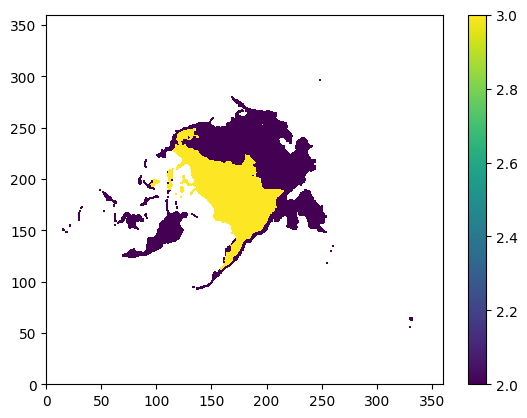

In [31]:
ice_type = nc.Dataset('/home/erb/masterproject/MSCI_project/snow_ice/carmen/icetype/icetype.nc').variables['Ice Type'][3240]
plt.pcolor(ice_type)
plt.colorbar()

In [32]:
# change this according to date
IS2 = np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2018_25km_20181215.npy")
cs = np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2018-2019_25km_20181215.npy")

path_IS2 = "/home/erb/masterproject/MSCI_project/snow_ice/carmen/non_interpolated_data/freeboard_daily_processed/IS2/dailyFB_25km_2018-2019_season.pkl"
path_CS2 = "/home/erb/masterproject/MSCI_project/snow_ice/carmen/non_interpolated_data/freeboard_daily_processed/CS2_LARM/dailyFB_25km_2018-2019_season.pkl"

f = open(path_IS2,'rb')
IS2_ni = pickle.load(f)

f = open(path_CS2,'rb')
CS2_ni = pickle.load(f)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


IS2_ni_1, IS2_ni_2, IS2_ni_3, IS2_ni_4, IS2_ni_5, IS2_ni_6, IS2_ni_7 = IS2_ni['20190215'], IS2_ni['20190216'], IS2_ni['20190217'], IS2_ni['20190218'], IS2_ni['20190219'], IS2_ni['20190214'], IS2_ni['20190213']
CS2_ni_1, CS2_ni_2, CS2_ni_3, CS2_ni_4, CS2_ni_5  = CS2_ni['20190415'], CS2_ni['20190416'], CS2_ni['20190417'], CS2_ni['20190418'], CS2_ni['20190419']


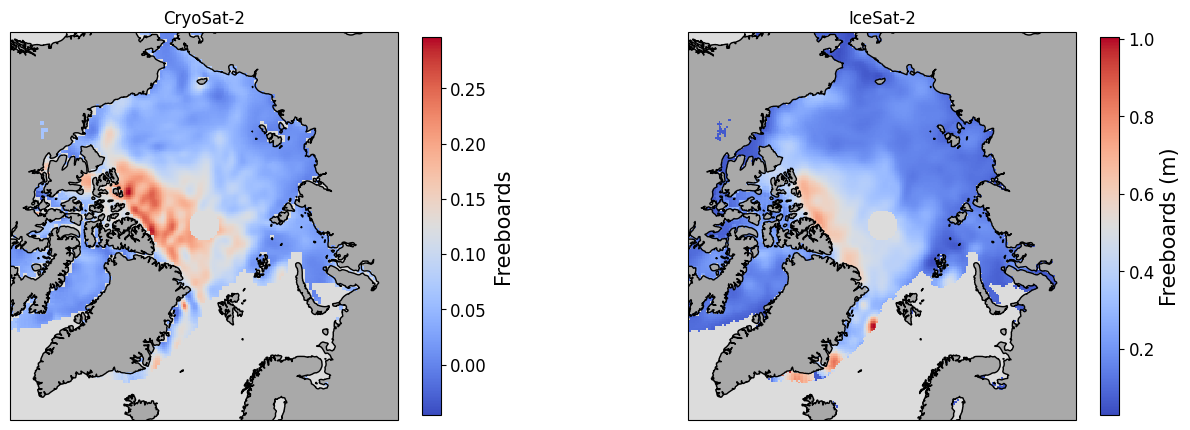

In [33]:
fig = plt.figure(figsize = (15,7))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.4)

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, cs,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
plt.title('CryoSat-2')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('Freeboards',fontsize=15)


ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
plt.title("IceSat-2")
a = fig.colorbar(p_map, shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('Freeboards (m)',fontsize=15)



In [34]:
ice_inverse = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_ice.npy')

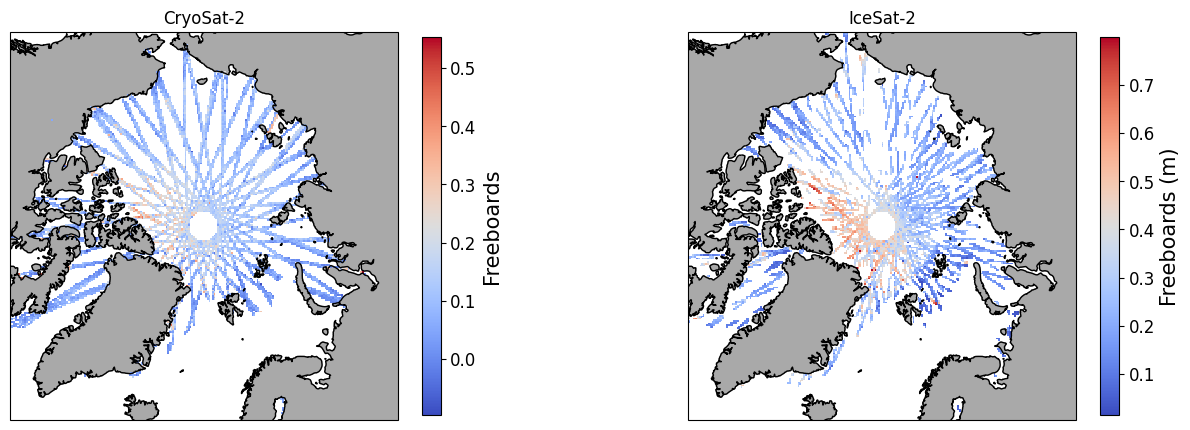

In [35]:
fig = plt.figure(figsize = (15,7))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.4)

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='white', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, CS2_ni_1,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, CS2_ni_2,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, CS2_ni_3,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, CS2_ni_4,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, CS2_ni_5,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
plt.title('CryoSat-2')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('Freeboards',fontsize=15)


ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='white', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_1,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_2,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_3,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_4,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_5,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_6,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, IS2_ni_7,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())

plt.title("IceSat-2")
a = fig.colorbar(p_map, shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('Freeboards (m)',fontsize=15)



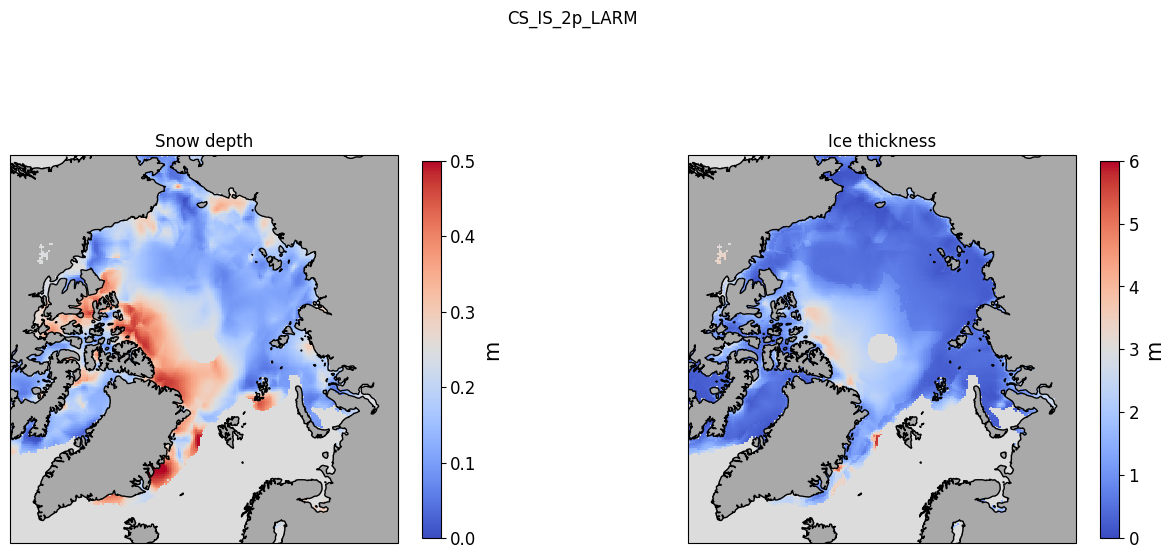

In [36]:
# change this for different dates, inversion images all in images\
snow = np.loadtxt("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/images_2/20181215.npy_snow")
ice = np.loadtxt("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/images_2/20181215.npy_ice")

snow = mask_observations(IS2, snow)
ice = compute_ice(ice, '20181115')
ice = mask_observations(IS2, ice)


fig = plt.figure(figsize = (15,7))
plt.suptitle('CS_IS_2p_LARM')
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.4)

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, snow,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)
plt.title('Snow depth')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('m',fontsize=15)


ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, ice,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
plt.title("Ice thickness")
a = fig.colorbar(p_map, shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('m',fontsize=15)


if save_fig == 1 :  
    tesselation = "Delaunay" #InversionBinnedParallel.parametrization
    init_cell   = "1500" #InversionBinnedParallel.initial_cells
    iteration   = "1500000" #InversionBinnedParallel.iterations_number
    date        = "201812/15" #InversionBinnedParallel.date
    slide_window = "15j" 
    ice_density  = "mixte"
    alpha_cs2 = "0.75"
    hierarchical = "no"
    name_type_run = "tesselation" + tesselation + "_initcell" + init_cell + "_iteration" + iteration + "_date" + "_window" + slide_window + "_icedensity" + ice_density + "_alphacs2" + alpha_cs2 + "_hierarchical" + hierarchical 
    
    plt.savefig("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_plot/non_interpolated_input/" + date +name_type_run +'.png')
    np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/' + date + name_type_run + '_snow', snow)
    np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/' + date + name_type_run + '_ice', ice)




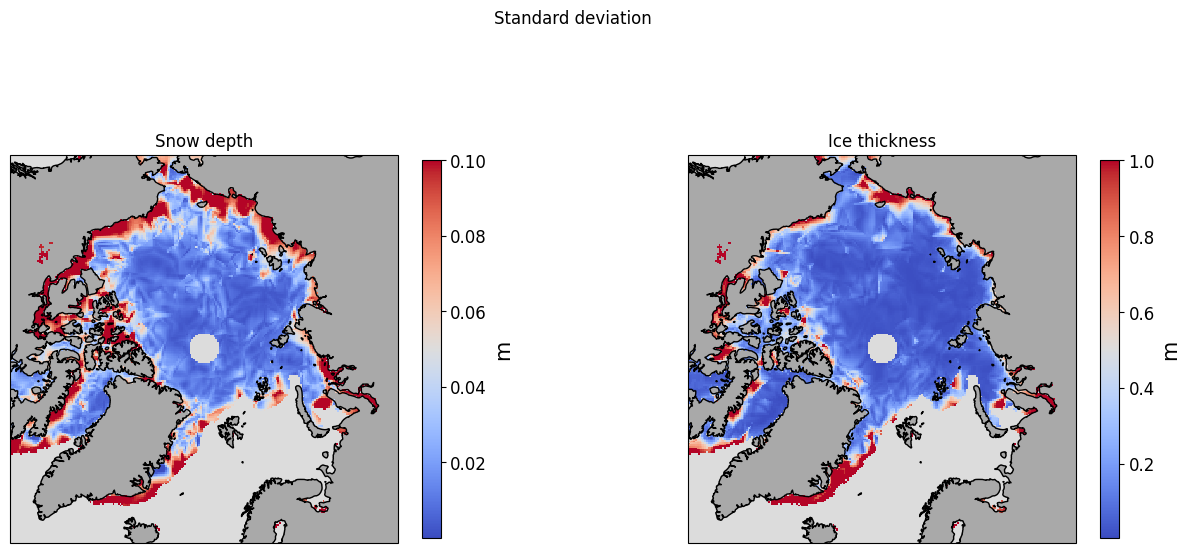

In [37]:
# change this for different dates, inversion images all in images\
snow = np.loadtxt("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/images_2/20181215.npy_snow_stddev")
ice = np.loadtxt("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/images_2/20181215.npy_ice_stddev")

snow = mask_observations(IS2, snow)
ice = mask_observations(IS2, ice)
ice = compute_ice(ice, '20181115')


fig = plt.figure(figsize = (15,7))
plt.suptitle('Standard deviation')


spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.4)

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, snow,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmax = 0.1)
plt.title('Snow depth')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('m',fontsize=15)


ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, ice,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmax = 1)
plt.title("Ice thickness")
a = fig.colorbar(p_map, shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('m',fontsize=15)

if save_fig == 1 :  
    tesselation = "Delaunay" #InversionBinnedParallel.parametrization
    init_cell   = "1500" #InversionBinnedParallel.initial_cells
    iteration   = "1500000" #InversionBinnedParallel.iterations_number
    date        = "201811/15" #InversionBinnedParallel.date
    slide_window = "15j" 
    ice_density  = "mixte"
    alpha_cs2 = "0.75"
    hierarchical = "no"
    name_type_run = "tesselation" + tesselation + "_initcell" + init_cell + "_iteration" + iteration + "_date" + "_window" + slide_window + "_icedensity" + ice_density + "_alphacs2" + alpha_cs2 + "_hierarchical" + hierarchical 

    plt.savefig("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_plot/non_interpolated_input/" + date + name_type_run + '_stddev' + '.png')
    np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/' + date + name_type_run + '_snow_stddev', snow)
    np.save('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/' + date + name_type_run + '_ice_stddev', ice)


plt.show()

In [38]:
stop
# prints out acceptance rates of the latest inversion
file = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results/log.txt-000'

iterations = np.arange(5000,1000001,5000)

keywords = ["Value", "Move", "Birth", "Death", "Hierarchical", "Cells"]

rate = {key: {"snow": [], "ice": []} for key in keywords}

with open(file) as f:
    for line in f:
        data = line.split()

        for key in keywords:
            if key in line:
                rate[key]["snow"].append(float(data[4]))
                rate[key]["ice"].append(float(data[9]))

        if "Cell(s)" in line:
            parts = line.split("Cell(s)")
            if len(parts) > 1:
                values_str = parts[1].strip()
                values = [int(x) for x in values_str.split()]
                if len(values) >= 2:
                    rate["Cells"]["snow"].append(values[0])
                    rate["Cells"]["ice"].append(values[1])

            

plt.figure(figsize=(13,12))
plt.suptitle('Proposal Acceptance Rate vs Iterations')

plt.subplot(6,2,1)
plt.plot(iterations, rate["Value"]["snow"], '-')
plt.ylabel("Value")
plt.title('Snow')

plt.subplot(6,2,2)
plt.plot(iterations, rate["Value"]["ice"],'-')
plt.title('Ice')

plt.subplot(6,2,3)
plt.plot(iterations, rate["Move"]['snow'],'-')
plt.ylabel("Move")

plt.subplot(6,2,4)
plt.plot(iterations, rate["Move"]['ice'],'-')

plt.subplot(6,2,5)
plt.plot(iterations, rate["Birth"]['snow'],'-')
plt.ylabel("Birth")
plt.subplot(6,2,6)
plt.plot(iterations, rate["Birth"]['ice'],'-')

plt.subplot(6,2,7)
plt.plot(iterations, rate["Death"]['snow'],'-')
plt.ylabel("Death")
plt.subplot(6,2,8)
plt.plot(iterations, rate["Death"]['ice'],'-')

#plt.subplot(6,2,9)
#plt.plot(iterations, rate["Hierarchical"]['snow'],'-')
#plt.ylabel("Hierarchical")
#plt.subplot(6,2,10)
#plt.plot(iterations, rate["Hierarchical"]['ice'],'-')

plt.subplot(6,2,9)
plt.plot(iterations, rate["Cells"]['snow'],'-')
plt.ylabel("Cells")
plt.subplot(6,2,10)
plt.plot(iterations, rate["Cells"]['ice'],'-')


if save_fig == 1 :  
    tesselation = "Delaunay" #InversionBinnedParallel.parametrization
    init_cell   = "1500" #InversionBinnedParallel.initial_cells
    iteration   = "1500000" #InversionBinnedParallel.iterations_number
    date        = "201904/15" #InversionBinnedParallel.date
    slide_window = "15j" 
    error  = "input"
    alpha_cs2 = "0.75"
    hierarchical = "no"
    name_type_run = "tesselation" + tesselation + "_initcell" + init_cell + "_iteration" + iteration + "_date" + "_window" + slide_window + "_error" + error + "_alphacs2" + alpha_cs2 + "_hierarchical" + hierarchical 
    plt.savefig("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_plot/non_interpolated_input/" + date + name_type_run + '_rates' + '.png')

plt.show()

NameError: name 'stop' is not defined

In [ ]:
stop
# change this for different dates, inversion images all in images\
snow = np.loadtxt("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/images/20190417.npy_snow_median")
ice = np.loadtxt("/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/images/20190417.npy_ice_median")

snow = mask_observations(IS2, snow)
ice = mask_observations(IS2, ice)

fig = plt.figure(figsize = (15,7))
plt.suptitle('Median')


spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.4)

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, snow,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
plt.title('Snow depth')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('m',fontsize=15)


ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax2.pcolormesh(lon_g,lat_g, ice,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree())
plt.title("Ice thickness")
a = fig.colorbar(p_map, shrink=0.7, pad=0.05)
a.ax.tick_params(labelsize=12)
a.set_label('m',fontsize=15)


NameError: name 'stop' is not defined

In [ ]:
file_path = '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/images/20190417.npy_snow_histo'

with open(file_path, 'r') as file:
    content = file.read(1000)  # Lire les 100 premiers caractères
    print(content)


360 360 500
  0.000000 1000.000000
72004 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
stop
# change this for different dates
IS2 = np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2018_25km_20181115.npy")
cs = np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2018-2019_25km_20181115.npy")

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

NameError: name 'stop' is not defined

In [ ]:
#Loading AWISMOS
filename = '/home/hds/DATA/AWI_SIT/SMOS_daily/2019/11/W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_20191109_20191115_r_v202_02_l4sit.nc'
AWISMOS = nc.Dataset(filename)





NameError: name 'nc' is not defined

In [ ]:
AWISMOS.variables.keys()

dict_keys(['Lambert_Azimuthal_Grid', 'time', 'time_bnds', 'xc', 'yc', 'lon', 'lat', 'analysis_sea_ice_thickness', 'background_sea_ice_thickness', 'weighted_mean_sea_ice_thickness', 'innovation', 'sea_ice_concentration', 'sea_ice_type', 'correlation_length_scale', 'analysis_sea_ice_thickness_unc', 'smos_sea_ice_thickness', 'cryosat_sea_ice_thickness'])

In [ ]:
lon_AWISMOS = AWISMOS.variables['lon']
lat_AWISMOS = AWISMOS.variables['lat']
SIT_AWISMOS = AWISMOS.variables['analysis_sea_ice_thickness']


In [ ]:
print(SIT_AWISMOS)

<class 'netCDF4._netCDF4.Variable'>
int32 analysis_sea_ice_thickness(time, yc, xc)
    units: m
    long_name: CS2SMOS merged sea ice thickness
    standard_name: sea_ice_thickness
    grid_mapping: Lambert_Azimuthal_Grid
    coordinates: time lat lon
    scale_factor: 0.001
    _FillValue: -2147483647
unlimited dimensions: time
current shape = (1, 432, 432)
filling on


In [ ]:
from mpl_toolkits.basemap import Basemap

# Define the lon and lat coordinates
lon = -120.0  # Longitude
lat = 80.0    # Latitude
# Create a Basemap instance with EPSG 3408 projection
m = Basemap(projection='stere',             
            lon_0=0, lat_0=90,    # Center of the projection (North Pole)            
            llcrnrlon=-180, llcrnrlat=60, urcrnrlon=180, urcrnrlat=90,  # Lower-left and upper-right corners of the map            
            resolution='l',       # Resolution ('l' = low, 'h' = high)            
            epsg=3408)            # EPSG code for NSIDC Sea Ice Polar Stereographic North

# Project lon, lat to x, y
AWISMOS_x, AWISMOS_y = m(np.asarray(lon_AWISMOS),np.asarray(lat_AWISMOS))


ZeroDivisionError: float division by zero

In [ ]:
print(AWISMOS_x)

[[-5383259.64458054 -5358217.14427255 -5333174.86817517 ...
   5333174.86817517  5358217.14427255  5383259.64458054]
 [-5383196.0477524  -5358153.77823525 -5333111.65667623 ...
   5333111.65667623  5358153.77823525  5383196.0477524 ]
 [-5383133.19537961 -5358090.53310087 -5333048.54272124 ...
   5333048.54272124  5358090.53310087  5383133.19537961]
 ...
 [-5383133.90553475 -5358090.88817425 -5333048.54272124 ...
   5333048.54272124  5358090.88817425  5383133.90553475]
 [-5383196.76124212 -5358153.77823525 -5333111.29993976 ...
   5333111.29993976  5358153.77823525  5383196.76124212]
 [-5383259.64458054 -5358216.42745659 -5333174.15136758 ...
   5333174.15136758  5358216.42745659  5383259.64458054]]


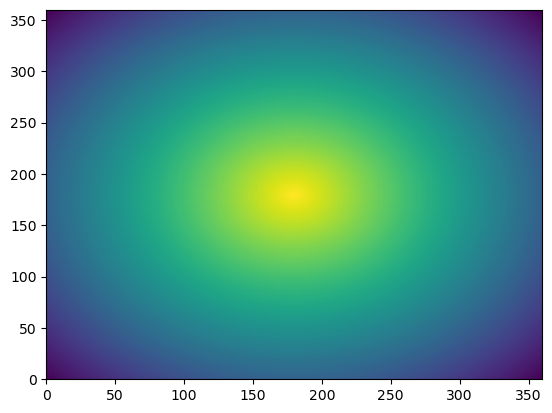

In [ ]:
plt.pcolor(lat_g)

In [ ]:
AWISMOS_x.shape

(432, 432)

In [ ]:
data_CS2 = nc.Dataset('/home/erb/masterproject/MSCI_project/non_interpolated_data/CS2/2019-03/03/CS_LTA__SIR_SAR_1B_20190311T061945_20190311T062207_D002.nc')


In [ ]:
data_CS2.variables.keys()

dict_keys(['agc_ch1_20_ku', 'agc_ch2_20_ku', 'alt_20_ku', 'alt_avg_01_ku', 'beam_dir_vec_20_ku', 'cor2_applied_20_ku', 'dop_angle_start_20_ku', 'dop_angle_stop_20_ku', 'dop_cor_20_ku', 'echo_numval_20_ku', 'echo_numval_avg_01_ku', 'echo_scale_factor_20_ku', 'echo_scale_factor_avg_01_ku', 'echo_scale_pwr_20_ku', 'echo_scale_pwr_avg_01_ku', 'flag_echo_20_ku', 'flag_echo_avg_01_ku', 'flag_instr_conf_rx_bwdt_20_ku', 'flag_instr_conf_rx_flags_20_ku', 'flag_instr_conf_rx_in_use_20_ku', 'flag_instr_conf_rx_str_in_use_20_ku', 'flag_instr_conf_rx_trk_mode_20_ku', 'flag_instr_mode_att_ctrl_20_ku', 'flag_instr_mode_flags_20_ku', 'flag_instr_mode_op_20_ku', 'flag_mcd_20_ku', 'flag_trk_cycle_20_ku', 'h0_applied_20_ku', 'h0_fai_word_20_ku', 'h0_lai_word_20_ku', 'instr_cor_gain_rx_20_ku', 'instr_cor_gain_tx_rx_20_ku', 'instr_cor_range_rx_20_ku', 'instr_cor_range_tx_rx_20_ku', 'instr_ext_ph_cor_20_ku', 'instr_int_ph_cor_20_ku', 'inter_base_vec_20_ku', 'lat_20_ku', 'lat_avg_01_ku', 'lon_20_ku', 'lon_av

In [ ]:
import datetime

def generate_date_table(start_date, end_date, interval_days):
    date_table = []
    current_date = start_date
    sub_table = []

    while current_date <= end_date:
        sub_table.append(current_date.strftime('%Y%m%d'))
        if len(sub_table) == interval_days:
            date_table.append(sub_table)
            sub_table = []
        current_date += datetime.timedelta(days=1)
    
    # Add remaining dates if the last sub_table has fewer than interval_days
    if sub_table:
        date_table.append(sub_table)

    return date_table

# Define the start and end dates
start_date = datetime.date(2019, 11, 1)
end_date = datetime.date(2020, 4, 30)
interval_days = 15

# Generate the date table
date_table = generate_date_table(start_date, end_date, interval_days)

# Print the result
for sub_table in date_table:
    print(sub_table)


['20191101', '20191102', '20191103', '20191104', '20191105', '20191106', '20191107', '20191108', '20191109', '20191110', '20191111', '20191112', '20191113', '20191114', '20191115']
['20191116', '20191117', '20191118', '20191119', '20191120', '20191121', '20191122', '20191123', '20191124', '20191125', '20191126', '20191127', '20191128', '20191129', '20191130']
['20191201', '20191202', '20191203', '20191204', '20191205', '20191206', '20191207', '20191208', '20191209', '20191210', '20191211', '20191212', '20191213', '20191214', '20191215']
['20191216', '20191217', '20191218', '20191219', '20191220', '20191221', '20191222', '20191223', '20191224', '20191225', '20191226', '20191227', '20191228', '20191229', '20191230']
['20191231', '20200101', '20200102', '20200103', '20200104', '20200105', '20200106', '20200107', '20200108', '20200109', '20200110', '20200111', '20200112', '20200113', '20200114']
['20200115', '20200116', '20200117', '20200118', '20200119', '20200120', '20200121', '20200122'

In [ ]:
date_table[7]

['20200214',
 '20200215',
 '20200216',
 '20200217',
 '20200218',
 '20200219',
 '20200220',
 '20200221',
 '20200222',
 '20200223',
 '20200224',
 '20200225',
 '20200226',
 '20200227',
 '20200228']

In [ ]:
data_test = data_CS2['orb_alt_rate_20_ku']
print(data_test)

<class 'netCDF4._netCDF4.Variable'>
int32 orb_alt_rate_20_ku(time_20_ku)
    _FillValue: -2147483648
    add_offset: 0.0
    comment: Instantaneous altitude rate at the satellite CoM with respect to the reference ellipsoid [WGS84].
    coordinates: lon_20_ku lat_20_ku
    long_name: altitude rate of the Satellite CoM with respect to the reference ellipsoid
    scale_factor: 0.001
    units: m/s
unlimited dimensions: 
current shape = (3146,)
filling on
